In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../")

from src import Netlist, LumpedElement, WDFScheme
from src import Resistor, Capacitor, VoltageSource, VCVS
from scipy.signal import freqz

In [2]:
class ImpulseResponse:
    def __init__(self, samplerate: int, impulse_response: np.ndarray | list[float]) -> None:
        w, h = freqz(impulse_response, 1, 2**16)
        self._samplerate: int = samplerate
        self._power: np.ndarray = 20 * np.log10(np.abs(h))
        self._frequency: np.ndarray = w / (2 * np.pi) * samplerate
    
    def show(self, min_freq: int = 0, max_freq: int | None = None) -> None:
        plt.figure(figsize=(10, 6))
        plt.grid()
        if max_freq is None:
            max_freq = self._samplerate // 2
        plt.semilogx(self._frequency, self._power)
        plt.xlim(min_freq, max_freq)
        plt.ylim(-20, 5)
        plt.title("Impulse response of the analog filter")
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("Magnitude [dB]")
        plt.show()

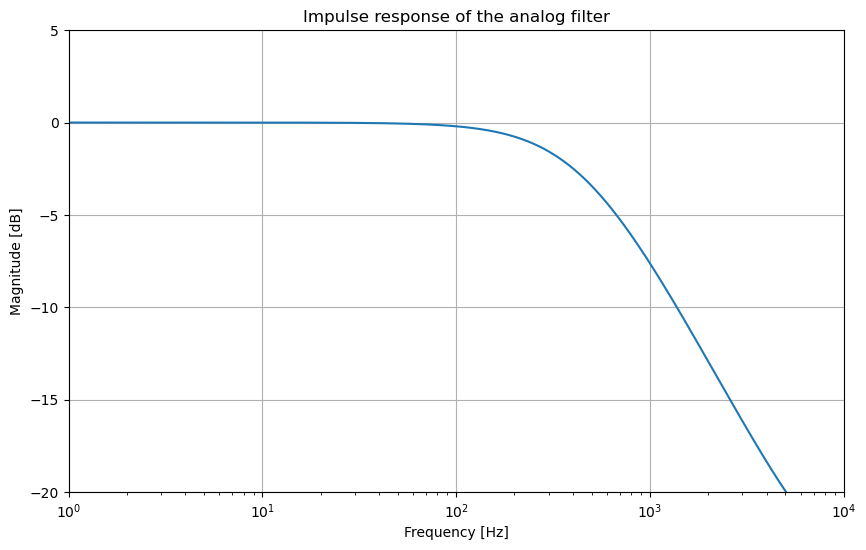

In [3]:
# lowpass filter
lowpass: Netlist = Netlist(
    LumpedElement("input", VoltageSource(1e-3), (0, 1)),
    LumpedElement("r", Resistor(10), (0, 2)),
    LumpedElement("c", Capacitor(3.5e-5), (2, 1))
)

samplerate: int = 20000
wdf: WDFScheme = WDFScheme(samplerate, lowpass)
# Dirac delta function
delta: list = [1.0] + [0] * 5000
impulse_response: np.ndarray = wdf.process_signal({"input": delta}, keys=["c"])["c"]
ImpulseResponse(samplerate, impulse_response).show(1, 10000)

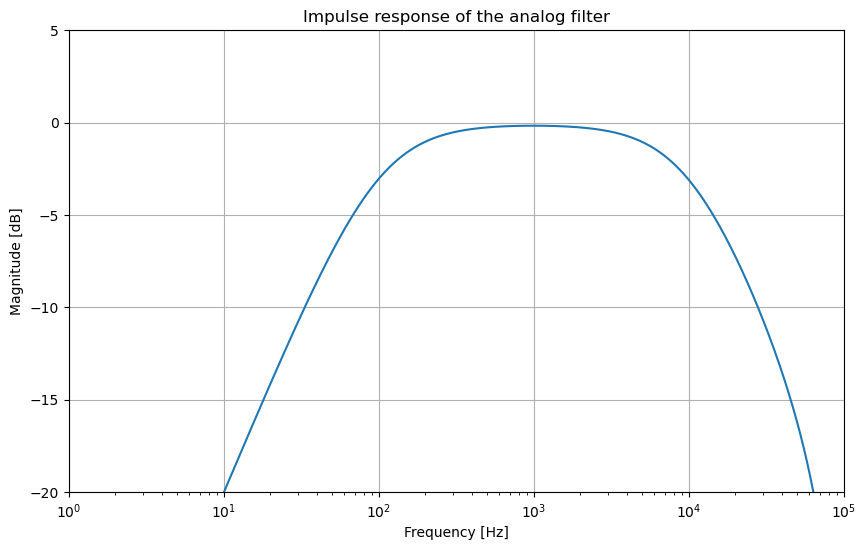

In [4]:
# bandpass filter
bandpass: Netlist = Netlist(
    LumpedElement("input", VoltageSource(1e-3), (0, 1)),
    LumpedElement("c1", Capacitor(100 * 1e-9), (0, 2)),
    LumpedElement("r1", Resistor(15924), (2, 1)),
    LumpedElement("c2", Capacitor(1e-9), (3, 1)),
    LumpedElement("r2", Resistor(15924), (2, 3))
)

samplerate = 200000
wdf: WDFScheme = WDFScheme(samplerate, bandpass, outputs=[(3, 1)])
# Dirac delta function
delta = [1] + [0] * 30000
impulse_response = wdf.process_signal({"input": delta})[0]
ImpulseResponse(samplerate, impulse_response).show(1, 100000)